In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime
from copy import deepcopy
from collections import Counter
import pickle
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')



In [2]:
data = pd.read_csv('/Users/javadzabihi/Git-Python/Amazon_Reviews/Reviews.csv')
data.head(4)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [3]:
data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
data.isnull().sum()




Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [5]:
# Converting Unix time to date time
data['Time'] = pd.to_datetime(data['Time'],unit='s')
# data_sorted_by_time = data.sort_values('Time')
# Think about it
# It may be useful to implement Hidden Markov Model




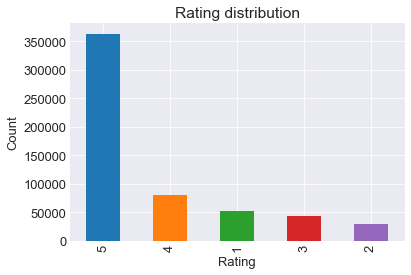

In [6]:
plt.rc('font', size = 13)
data.Score.value_counts().plot(kind = 'bar')
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()




In [7]:
# "Positive" : 1, "Negative": 0
data['Sentiment'] = data['Score'].apply(lambda score: 1 if score > 3 else 0)

data.Sentiment.value_counts()



1    443777
0    124677
Name: Sentiment, dtype: int64

In [8]:
from nltk.stem.porter import PorterStemmer


# One way to split the text corpora into individual elements is
# to split them into individual words by splitting the cleaned documents 
# at its whitespace characters.

def tokenizer(text):
    return text.split()


# A useful technique in the context of tokenization is word stemming, which
# is the process of transforming a word into its root form. 
# It allows us to map related words to the same stem.

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]


In [9]:
import nltk

nltk.download('stopwords')

# Removing stop-words can be useful if we are working with raw or 
# normalized term frequencies rather than tf-idfs, which are already 
# downweighting frequently occurring words.

from nltk.corpus import stopwords

stop = stopwords.words('english')




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javadzabihi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Term Frequency-Inverse Document Frequency

When we are dealing with text data, we often encounter words that occur across multiple documents. Those frequently occurring words typically don't contain useful information. So, we can use a technique called term frequency-inverse document frequency (tf-idf) that can downweight those frequently occurring words in the feature vectors. The tf-idf can be calculated as the product of the term frequency and the inverse document frequency.

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$

$n_d$ : the total number of documents 

df(d, t) : the number of documents 'd' that contain the term 't'

In [10]:
### I'm choosing a very small subset of the dataset to speed up the run
X = data.loc[:500,'Text']
y = data.loc[:500,'Sentiment']




In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)




# Sentiment analysis

# Logistic Regression

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


###### TfidfVectorizer combines the task of CountVectorizer and TfidfTransformer.
# from sklearn.feature_extraction.text import CountVectorizer
# count = CountVectorizer()
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf = TfidfTransformer(use_idf=True, 
#                         norm='l2', 
#                         smooth_idf=True)
# tfidf.fit_transform(count.fit_transform(text)).toarray()

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

# Using a GridSearchCV object to find the optimal set of parameters 
# for our logistic regression model.

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)




In [13]:
gs_lr_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

# The "best_score_" attribute returns the average score over the k-folds of the best model.
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))




Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   56.4s finished


Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x10d226598>, 'vect__use_idf': False} 
CV Accuracy: 0.828
Test Accuracy: 0.861


In [14]:
# The best grid search results using Porter stemming instead of the regular tokenizer, 
# no stop-word library, and a logistic regression classifier 
# that uses L2-regularization with the regularization strength C of 10.0
# based of raw term frequencies.
# regularization strengths is defined by the inverse-regularization parameter C.

# The "gs_lr_tfidf.best_score_" is the average k-fold cross-validation score. 
# For instance, if we have a GridSearchCV object with 10-fold cross-validation, 
# the "best_score_" attribute returns the average score over the 10-folds of the best model.



# Support Vector Classifier

In [15]:
from sklearn.svm import SVC

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [None],
               'vect__tokenizer': [tokenizer_porter],
               'clf__gamma': [0.01, 0.1, 1],
               'clf__C': [0.01, 0.1, 1.0],
               'clf__kernel': ['linear', 'rbf']}]

svc_tfidf = Pipeline([('vect', tfidf), 
                      ('clf', SVC(random_state=1))])

gs_svc_tfidf = GridSearchCV(svc_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)



In [16]:
gs_svc_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_svc_tfidf.best_params_)

# The "best_score_" attribute returns the average score over the k-folds of the best model.
print('CV Accuracy: %.3f' % gs_svc_tfidf.best_score_)

clf = gs_svc_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))




Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   40.8s finished


Best parameter set: {'clf__C': 0.01, 'clf__gamma': 0.01, 'clf__kernel': 'linear', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x10d226598>} 
CV Accuracy: 0.818
Test Accuracy: 0.822


The best grid search results using the following values in the support vector classifier:

C = 0.01

gamma = 0.01

kernel = linear

# Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                       stop_words=None,
                       tokenizer=tokenizer_porter)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)





0.8217821782178217